 # IGNORING CURLY

In [3]:
import pystan
import numpy as np
from scipy import stats
import matplotlib.pyplot as plt
import pandas as pd
import seaborn

%matplotlib inline

In [5]:
### Import get columns and rows
data = pd.read_csv("co2.csv",sep=',', comment='"',header=None)


In [6]:
N = len(data)

n = 1500
n_future = N - n

stan_data = {
    'n': n,
    'n_future': n_future,
    'x': data.loc[:n-1][1]}  # Stan gets to see the first n data values only


In [24]:
# The Stan model. Running this cell compiles the Stan model, which takes
# some time.

stan_code = """
data {
    int<lower=0> n;        // The number of data
    real<lower=0> x[n];             // The data
    int<lower=0> n_future; // The number of future values to predict
}

parameters {
    // _____POLY_____
    real<lower=0> C0;                   // constant
    real<lower=0> C1;                   // x multiplier
    real<lower=0> C2;                   // x^2 multiplier
        
    // _____NOISE_____
    real<lower=0> sigma;

}

model {
    // _____PRIORS_____
    C0 ~ normal(300, 50);
    C1 ~ normal(0, 1);
    C2 ~ normal(0,1);
    sigma ~ gamma(1, 0.3);
    
    // _____MODEL_____
    for(t in 1:n) {
        x[t] ~ normal(
            C0 + C1*t + C2*t^2,
            sigma^2);
    }
}

"""

stan_model = pystan.StanModel(model_code=stan_code)

INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_b5bf8cf4380d8721f29458c21b3d9b4b NOW.


In [25]:
# Run Hamiltonian Monte Carlo using Stan with 4 Markov chains, a 1000 step
# warm-up phase and 1000 step sampling phase for each chain. The warm-up samples
# are discarded, so we are left with 4 x 1000 = 4000 samples.

# This cell will take a minute or two to run.

parameters = ['C0','C1','C2','sigma']

results = stan_model.sampling(data=stan_data)
print(results.stansummary(pars=parameters))
samples = results.extract()

Inference for Stan model: anon_model_b5bf8cf4380d8721f29458c21b3d9b4b.
4 chains, each with iter=2000; warmup=1000; thin=1; 
post-warmup draws per chain=1000, total post-warmup draws=4000.

        mean se_mean     sd   2.5%    25%    50%    75%  97.5%  n_eff   Rhat
C0    315.28  3.9e-3   0.15 314.98 315.18 315.28 315.38 315.57   1553    1.0
C1      0.01  1.4e-5 4.7e-4   0.01   0.01   0.01   0.01   0.01   1201    1.0
C2    6.4e-6  8.7e-9 3.0e-7 5.8e-6 6.2e-6 6.5e-6 6.7e-6 7.0e-6   1214    1.0
sigma   1.43  3.3e-4   0.01   1.41   1.42   1.43   1.44   1.46   1501    1.0

Samples were drawn using NUTS at Sun Dec 15 21:42:37 2019.
For each parameter, n_eff is a crude measure of effective sample size,
and Rhat is the potential scale reduction factor on split chains (at 
convergence, Rhat=1).


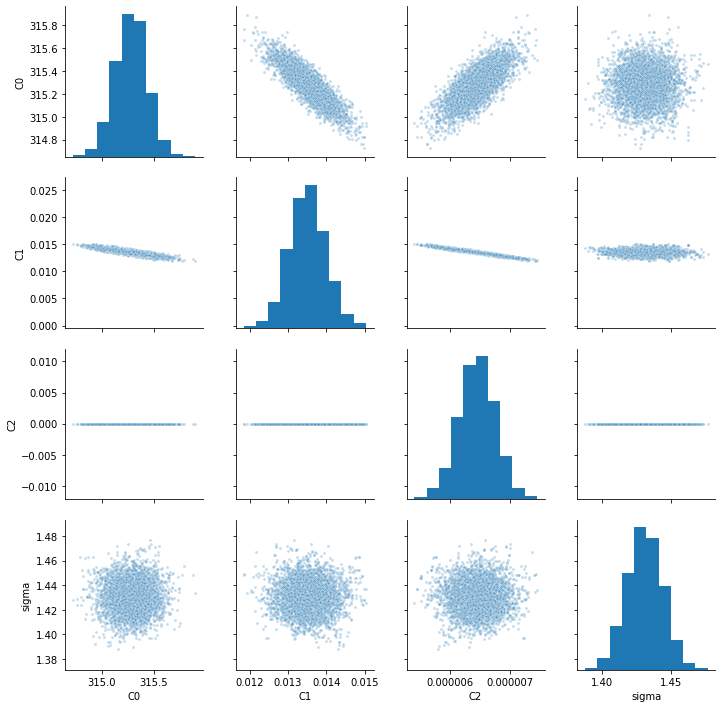

In [26]:
# Make pair plot of the posteriors over all parameters of the model.
df = pd.DataFrame(
    data=np.transpose([samples[param] for param in parameters]),
    columns=parameters)
seaborn.pairplot(df, size=2.5, plot_kws={'marker': '.', 'alpha': 0.25})
plt.show()

In [27]:
#'C1','C2','C3','A', 'lambda', 'phi', 'sigma'
pi_c0 = np.percentile(samples["C0"], axis=0, q=[2.5, 97.5])
pi_c1 = np.percentile(samples["C1"], axis=0, q=[2.5, 97.5])
pi_c2 = np.percentile(samples["C2"], axis=0, q=[2.5, 97.5])
pi_s = np.percentile(samples["sigma"], axis=0, q=[2.5, 97.5])

import math
pL = []
pU = []

for t in range(N):
    pL.append(stats.norm.rvs(pi_c0[0] + pi_c1[0]*t + pi_c2[0]*t**2, pi_s[0]**2))
    pU.append(stats.norm.rvs(pi_c0[1] + pi_c1[1]*t + pi_c2[1]*t**2, pi_s[1]**2))

    

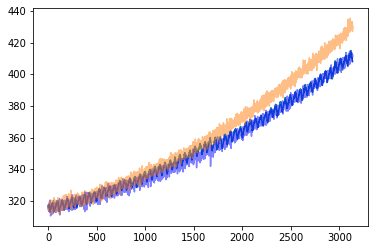

In [30]:
plt.plot([i for i in range(N)],data.loc[:][1]);
plt.plot([i for i in range(N)],pL,alpha=0.5,c="b");
plt.plot([i for i in range(N)],pU,alpha=0.5);
